In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
import numpy as np

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

In [2]:
df = pd.read_csv('../data/interim/airports.csv', index_col=0)

In [3]:
df.head()

,ANC,ATL,BOI,BZN,DEN,DFW,FLL,LAS,LAX,MCO,MIA,MSO,PDX,PHX,SEA,SFO,SJC,TPA
2018-12-30 00:00:00,115.0,11.0,NaN,NaN,123.0,NaN,0.0,343.0,533.0,NaN,283.0,NaN,14.0,389.0,50.0,318.0,NaN,1.0
2018-12-30 01:00:00,14.0,14.0,NaN,NaN,52.0,NaN,147.0,84.0,11.0,NaN,290.0,NaN,11.0,64.0,12.0,7.0,NaN,NaN
2018-12-30 02:00:00,29.0,10.0,NaN,NaN,19.0,NaN,NaN,60.0,NaN,NaN,314.0,NaN,24.0,16.0,110.0,NaN,NaN,NaN
2018-12-30 03:00:00,115.0,216.0,NaN,25.0,353.0,351.0,396.0,762.0,474.0,535.0,704.0,NaN,527.0,524.0,717.0,195.0,35.0,20.0
2018-12-30 04:00:00,305.0,1308.0,483.0,331.0,3006.0,2140.0,3217.0,3189.0,3778.0,3501.0,1796.0,190.0,1778.0,1919.0,3114.0,2361.0,420.0,2267.0


In [4]:
df = df.fillna(0)
df.head()

,ANC,ATL,BOI,BZN,DEN,DFW,FLL,LAS,LAX,MCO,MIA,MSO,PDX,PHX,SEA,SFO,SJC,TPA
2018-12-30 00:00:00,115.0,11.0,0.0,0.0,123.0,0.0,0.0,343.0,533.0,0.0,283.0,0.0,14.0,389.0,50.0,318.0,0.0,1.0
2018-12-30 01:00:00,14.0,14.0,0.0,0.0,52.0,0.0,147.0,84.0,11.0,0.0,290.0,0.0,11.0,64.0,12.0,7.0,0.0,0.0
2018-12-30 02:00:00,29.0,10.0,0.0,0.0,19.0,0.0,0.0,60.0,0.0,0.0,314.0,0.0,24.0,16.0,110.0,0.0,0.0,0.0
2018-12-30 03:00:00,115.0,216.0,0.0,25.0,353.0,351.0,396.0,762.0,474.0,535.0,704.0,0.0,527.0,524.0,717.0,195.0,35.0,20.0
2018-12-30 04:00:00,305.0,1308.0,483.0,331.0,3006.0,2140.0,3217.0,3189.0,3778.0,3501.0,1796.0,190.0,1778.0,1919.0,3114.0,2361.0,420.0,2267.0


In [5]:
df.isna().any().sum()

0

In [6]:
df.duplicated().any()

False

In [7]:
y=df['SFO'].loc['2022-01-18':'2022-01-26']

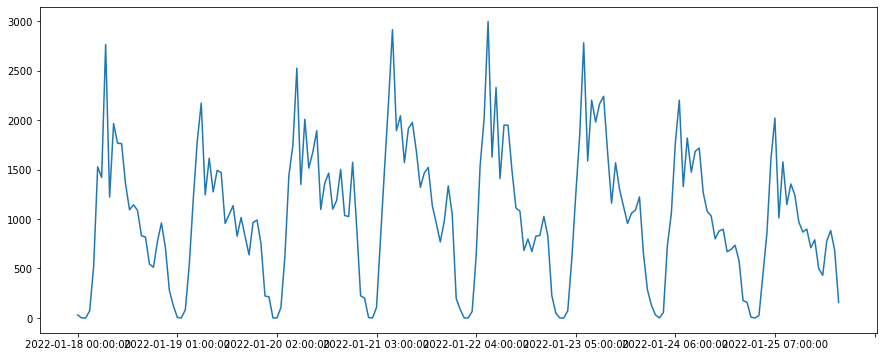

In [8]:
y.plot(figsize=(15,6));

In [9]:
kpssout = kpss(y, nlags='auto')
kpssout[1]

/Users/shaghayeghroshan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


0.1

In [10]:
y_novariance=np.sqrt(np.sqrt(y))

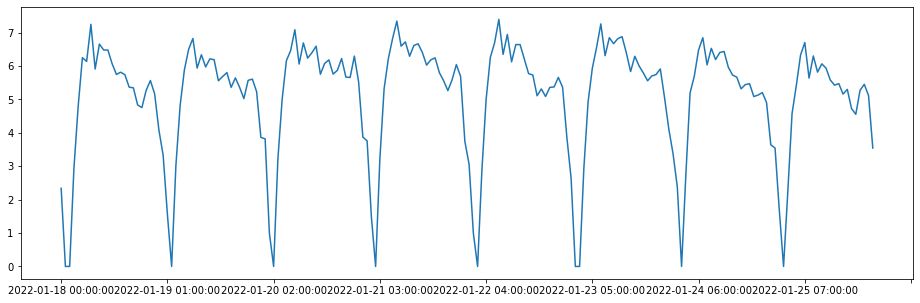

In [11]:
y_novariance.plot(figsize=(16,5));

In [12]:
kpssout = kpss(y_novariance, nlags='auto')
kpssout[1]

/Users/shaghayeghroshan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


0.1

In [13]:
y_stationary = y_novariance.diff()
y_stationary.dropna(inplace=True)

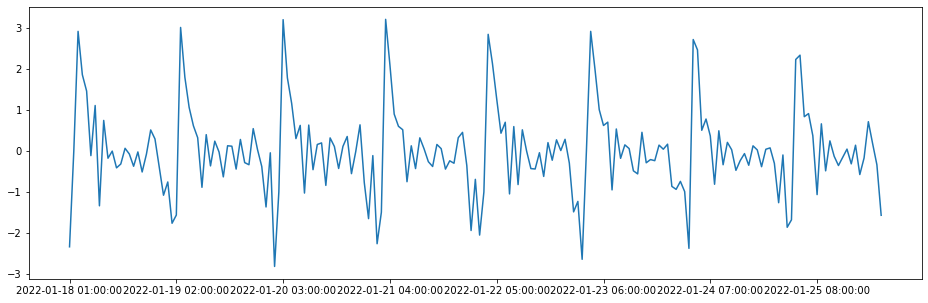

In [14]:
y_stationary.plot(figsize=(16,5));

In [15]:
kpssout = kpss(y_stationary, nlags='auto')
kpssout[1]

/Users/shaghayeghroshan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


0.1

In [16]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions. Declare a variable with that name
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        # Append() here
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [17]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [18]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [19]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y_novariance, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1.829
ARIMA(0, 0, 1) MSE=0.832
ARIMA(0, 0, 2) MSE=0.667
ARIMA(0, 1, 0) MSE=0.693
ARIMA(0, 1, 1) MSE=0.635
ARIMA(0, 1, 2) MSE=0.642
ARIMA(0, 2, 0) MSE=0.988
ARIMA(0, 2, 1) MSE=0.701
ARIMA(0, 2, 2) MSE=0.642
ARIMA(1, 0, 0) MSE=0.638
ARIMA(1, 0, 1) MSE=0.558
ARIMA(1, 0, 2) MSE=0.569
ARIMA(1, 1, 0) MSE=0.651
ARIMA(1, 1, 1) MSE=0.641
ARIMA(1, 1, 2) MSE=0.652
ARIMA(1, 2, 0) MSE=0.916
ARIMA(1, 2, 1) MSE=0.660
ARIMA(1, 2, 2) MSE=0.649
ARIMA(2, 0, 0) MSE=0.562
ARIMA(2, 0, 1) MSE=0.568
ARIMA(2, 1, 0) MSE=0.645
ARIMA(2, 1, 1) MSE=0.573
ARIMA(2, 1, 2) MSE=0.578
ARIMA(2, 2, 0) MSE=0.835
ARIMA(2, 2, 1) MSE=0.653
ARIMA(2, 2, 2) MSE=0.664
Best ARIMA(1, 0, 1) MSE=0.558


In [20]:
p=1
q=1
d=0
model = ARIMA(y_novariance, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34250D+00    |proj g|=  5.70604D-03

At iterate    5    f=  1.34234D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   2.220D-08   1.342D+00
  F =   1.3423394367471664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [21]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    SFO   No. Observations:                  192
Model:                     ARMA(1, 1)   Log Likelihood                -257.729
Method:                       css-mle   S.D. of innovations              0.923
Date:                Sun, 13 Mar 2022   AIC                            523.458
Time:                        20:57:33   BIC                            536.488
Sample:                    01-18-2022   HQIC                           528.736
                         - 01-25-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0762      0.314     16.151      0.000       4.460       5.692
ar.L1.SFO      0.6988      0.057     12.166      0.000       0.586       0.811
ma.L1.SFO      0.4393      0.064      6.812      0.000       0.313       0.566
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4309           +0.0000j            1.4309            0.0000
MA.1           -2.2766           +0.0000j            2.2766            0.5000
-----------------------------------------------------------------------------
"""

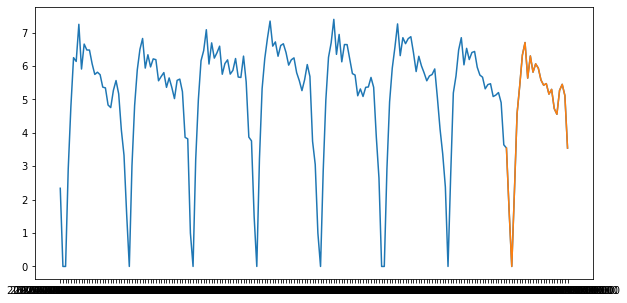

In [22]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
date_range = pd.date_range(y_novariance.index[-1], periods = forecast_period, 
              freq='M').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
future_months = pd.DataFrame(date_range, columns = ['Month'])
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast[0]

# Plot your future predictions
plt.figure(figsize=(10,5))
plt.plot(y_novariance)
plt.plot(y_novariance.loc['2022-01-25':]).append(future_months['Prediction']);

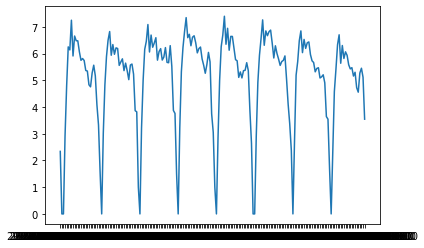

In [23]:
plt.plot(y_novariance);

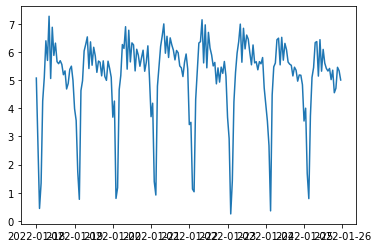

In [24]:
plt.plot(model_fit.predict());